In [1]:
import twixtools
from pygrappa import grappa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

from pylab import *
from matplotlib.widgets import LassoSelector
from mpl_interactions import image_segmenter

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

def phase_comb(sig, axis=1):
    return np.angle(np.sum(sig, axis))

In [2]:
# parse the twix files

# ## TR 1000
# twix_pre_noimp = twixtools.read_twix('meas_MID00930_FID96760_t1_gradient_echo_TR1000_baseline.dat')
# twix_post_noimp = twixtools.read_twix('meas_MID00938_FID96768_t1_gradient_echo_TR1000_postexposure.dat')

# twix_pre = twixtools.read_twix('meas_MID00939_FID96769_t1_gradient_echo_TR1000_baseline.dat')
# twix_post = twixtools.read_twix('meas_MID00943_FID96773_t1_gradient_echo_TR1000_postexposure.dat')

## TR 250
twix_pre_noimp = twixtools.read_twix('meas_MID00931_FID96761_t1_gradient_echo_TR250_baseline.dat')
twix_post_noimp = twixtools.read_twix('meas_MID00937_FID96767_t1_gradient_echo_TR250_postexposure.dat')

twix_pre = twixtools.read_twix('meas_MID00940_FID96770_t1_gradient_echo_TR250_baseline.dat')
twix_post = twixtools.read_twix('meas_MID00942_FID96772_t1_gradient_echo_TR250_postexposure.dat')

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix_pre_noimp))

Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 69.4MB/s]


Scan  1


100%|████████████████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 216MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 60.5MB/s]


Scan  1


100%|████████████████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 155MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 63.8MB/s]


Scan  1


100%|████████████████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 205MB/s]


Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████████████| 9.16M/9.16M [00:00<00:00, 62.5MB/s]


Scan  1


100%|████████████████████████████████████████████████████████████████████████████████████████| 11.2M/11.2M [00:00<00:00, 240MB/s]


number of separate scans (multi-raid): 2


In [3]:
twix_pre_noimp[-1]['hdr']['Phoenix']

SyntaxError: unmatched ')' (1673461578.py, line 1)

In [4]:
# Now do it all again for pre/post and abbreviate code 
def get_grappa_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    cal_data = mapped[-1]['refscan']
    im_data.flags['remove_os'] = False

    data = im_data[:].squeeze()
    data_cal = cal_data[:].squeeze()
    #print(data.shape, data_cal.shape)
    
    res = np.empty_like(data)
    for slice in np.arange(data.shape[slice_axis]):
        for contrast in np.arange(data.shape[contrast_axis]):
            data_contrast = data[slice, contrast,:,:,:]
            data_cal_contrast = data_cal[slice, contrast,22:46,:,:]
            #print(data_cal_contrast.shape, data_contrast.shape)
            res[slice, contrast,:,:,:] = grappa(data_contrast, data_cal_contrast, coil_axis=1, silent=True, kernel_size=(6,6))
    #print(res.shape)
    return res

def get_image_kspace(twix_data):
    mapped = twixtools.map_twix(twix_data)

    im_data = mapped[-1]['image']
    im_data.flags['remove_os'] = False
    data = im_data[:].squeeze()
    print(data.shape)

    return data

slice_axis = 0
contrast_axis = 1
coil_axis = 3

# # Summation approach to combine coils
# res_pre = get_grappa_kspace(twix_pre_noimp)
# res_post = get_grappa_kspace(twix_post_noimp)

# Select single coil that gives best signal
res_pre = get_grappa_kspace(twix_pre)
res_post = get_grappa_kspace(twix_post)

res_pre_noimp = get_grappa_kspace(twix_pre_noimp)
res_post_noimp = get_grappa_kspace(twix_post_noimp)

In [5]:
print(res_pre.shape)

image_pre = ifftnd(res_pre, [2,-1])
image_rms_pre = rms_comb(image_pre, coil_axis)
image_presum = np.sum(image_pre, coil_axis)
phase_img_pre = np.angle(image_presum)

image_post = ifftnd(res_post, [2,-1])
image_rms_post = rms_comb(image_post, coil_axis)
image_postsum = np.sum(image_post, coil_axis)
phase_img_post = np.angle(image_postsum)

image_pre_noimp = ifftnd(res_pre_noimp, [2,-1])
image_rms_pre_noimp = rms_comb(image_pre_noimp, coil_axis)
image_presum_noimp = np.sum(image_pre_noimp, coil_axis)
phase_img_pre_noimp = np.angle(image_presum_noimp)

image_post_noimp = ifftnd(res_post_noimp, [2,-1])
image_rms_post_noimp = rms_comb(image_post_noimp, coil_axis)
image_postsum_noimp = np.sum(image_post_noimp, coil_axis)
phase_img_post_noimp = np.angle(image_postsum_noimp)


(4, 4, 63, 4, 512)


(4, 4, 63, 4, 512)
(4, 4, 63, 512)


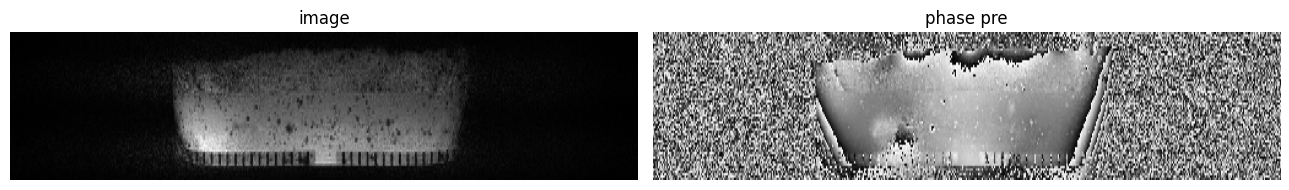

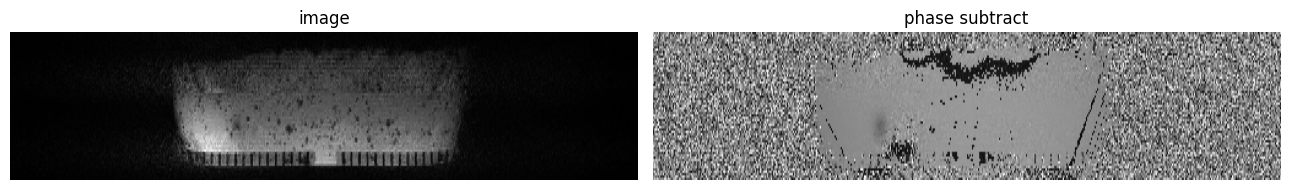

In [6]:
## Check kspace 

slice_index = 2
contrast_index = 2

print(image_pre.shape)
print(image_rms_pre.shape)
plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(image_rms_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')#,vmin=0)#, vmax=0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase pre')
plt.imshow(phase_img_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(image_rms_post[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')#,vmin=0)#, vmax=0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase subtract')
plt.imshow(phase_img_post[contrast_index,slice_index,:,:] - phase_img_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

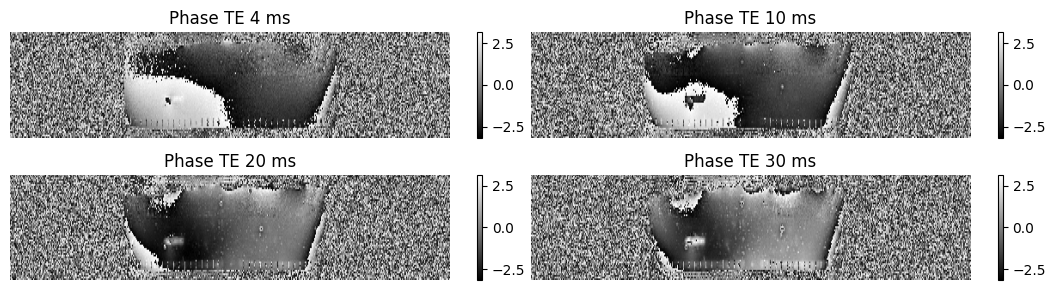

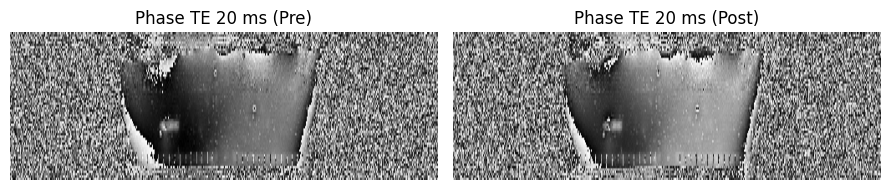

In [7]:
## Get Phase images for report
slice_index = 3
contrast_index = 2

phase_img_rep = np.angle(image_pre[:,:,:,1,:])
phase_img_rep_pre = np.angle(image_pre[:,:,:,1,:])
phase_img_rep_post = np.angle(image_post[:,:,:,1,:])

plt.figure(figsize=[11,3])
plt.subplot(221)
plt.title('Phase TE 4 ms')
plt.imshow(phase_img_rep[0,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')#,vmin=0)#, vmax=0.0009)
plt.colorbar()
plt.axis('off')

plt.subplot(222)
plt.title('Phase TE 10 ms')
plt.imshow(phase_img_rep[1,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.colorbar()
plt.tight_layout()

plt.subplot(223)
plt.title('Phase TE 20 ms')
plt.imshow(phase_img_rep[2,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')#,vmin=0)#, vmax=0.0009)
plt.colorbar()
plt.axis('off')

plt.subplot(224)
plt.title('Phase TE 30 ms')
plt.imshow(phase_img_rep[3,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.colorbar()
plt.show()


plt.figure(figsize=[9,2])
plt.subplot(121)
plt.title('Phase TE 20 ms (Pre)')
plt.imshow(phase_img_rep_pre[2,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')#,vmin=0)#, vmax=0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('Phase TE 20 ms (Post)')
plt.imshow(phase_img_rep_post[2,slice_index,:,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

0.03
(63, 512)


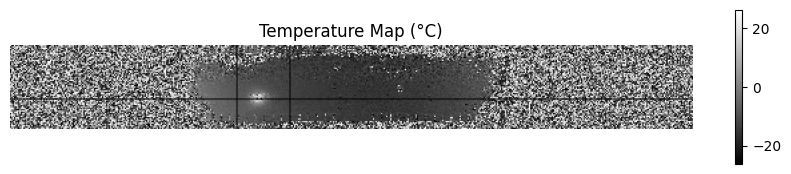

(63, 512)


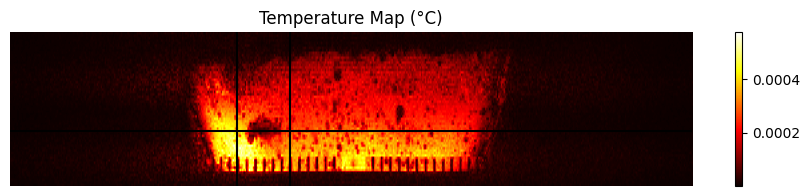

[-24.3 -22.5 -20.8 -19.1 -17.3 -15.6 -13.9 -12.1 -10.4  -8.7  -6.9  -5.2
  -3.5  -1.7   0.    1.7   3.5   5.2   6.9   8.7  10.4  12.1  13.9  15.6
  17.3  19.1  20.8  22.5  24.3  26.   27.7  29.5  31.2  32.9  34.7  36.4
  38.1  39.9  41.6  43.4]
[-30. -20. -10.   0.  10.  20.  30.  40.  50.]
[-30. -20. -10.   0.  10.  20.  30.  40.  50.]


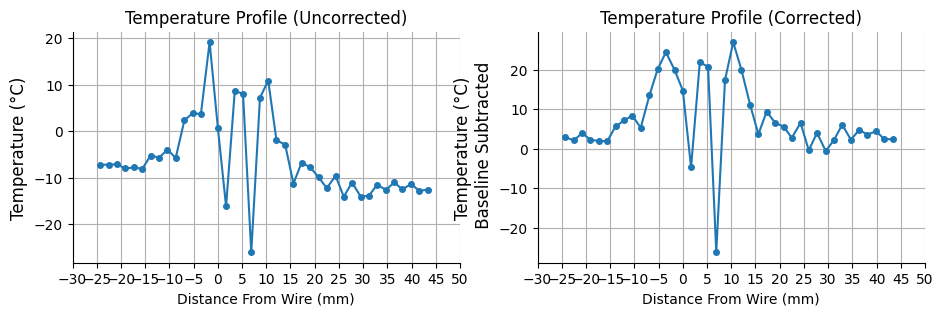

In [10]:
# Calculate temperature map
slice_index = 3
contrast_index = 2

alpha = 0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
TE = 0.040 #s

# Do first phase subtraction within acquisition
phase_sub_complex = np.angle(np.multiply(image_pre[contrast_index,slice_index,:,1,:],np.conjugate(image_post[contrast_index,slice_index,:,1,:])))
phase_sub_complex_noimp = np.angle(np.multiply(image_pre_noimp[contrast_index,slice_index,:,1,:],np.conjugate(image_post_noimp[contrast_index,slice_index,:,1,:])))
#temp_map_comb = (phase_img_post - phase_img_pre) / (alpha*gyromagnetic_ratio*B0*TE)
TE = twix_pre[-1]['hdr']['Phoenix']['alTE'][contrast_index]/1e6
print(TE)
temp_map = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)
temp_map_noimp = (phase_sub_complex_noimp) / (alpha*gyromagnetic_ratio*B0*TE)

# plt.figure(figsize=[11,2])
# plt.title('Phase Subtraction (Radians)')
# plt.imshow(phase_sub_complex, cmap='gray', origin='lower', aspect='auto')
# plt.colorbar()
# plt.axis('off')
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=[13,2])
# plt.subplot(121)
# plt.title('image')
# plt.imshow(image_rms_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
# plt.axis('off')

# plt.subplot(122)
# plt.title('Temp Map')
# plt.imshow(temp_map, cmap='gray', origin='lower', aspect='auto')
# plt.axis('off')
# plt.colorbar()
# plt.tight_layout()
# plt.show()

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

xstart, xstop = 170, 210
ystart, ystop = 22, 22

plt.figure(figsize=[11,2])
plt.title('Temperature Map (°C)')
print(temp_map.shape)
plt.plot([0,512],[ystart,ystop], 'k-',alpha=0.5)
plt.plot([xstart,xstart],[0,63], 'k-',alpha=0.5)
plt.plot([xstop,xstop],[0,63], 'k-',alpha=0.5)
plt.imshow(temp_map, origin='lower', cmap='gray')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

plt.figure(figsize=[11,2])
plt.title('Temperature Map (°C)')
print(temp_map.shape)
plt.plot([0,512],[ystart,ystop], 'k-',alpha=1)
plt.plot([xstart,xstart],[0,63], 'k-',alpha=1)
plt.plot([xstop,xstop],[0,63], 'k-',alpha=1)
plt.imshow(image_rms_post[contrast_index, slice_index] , aspect='auto', origin='lower',cmap='hot')
plt.axis('off')
plt.colorbar()
#plt.tight_layout()
plt.show()

temp_profile_noimp = moving_average(temp_map_noimp[ystart,xstart:xstop],1)
temp_profile = moving_average(temp_map[ystart,xstart:xstop],1)
temp_drift = 0.5 - temp_profile_noimp

voxel_dist = np.round(np.arange(0,xstop-xstart)*1.734 - 24.276,1)
print(voxel_dist)

%matplotlib inline

title = "Temperature Profiles"
fig = plt.figure(figsize=(11,3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(voxel_dist, temp_profile, linestyle='-', marker='o', markersize=4)
#fig.suptitle(title,fontsize=20)
ax1.set_title("Temperature Profile (Uncorrected)")
ax1.set_xlabel('Distance From Wire (mm)')
ax1.set_ylabel('Temperature (°C)',fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

current_ticks = ax1.get_xticks()
print(current_ticks)
num_ticks = len(current_ticks) * 2 - 1  # This ensures doubling the count
new_step = (current_ticks[-1] - current_ticks[0]) / (num_ticks - 1)
new_ticks = np.linspace(current_ticks[0], current_ticks[-1], num_ticks)
ax1.set_xticks(new_ticks)

ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(voxel_dist, temp_profile + temp_drift, linestyle='-', marker='o', markersize=4)
#fig.suptitle(title,fontsize=20)
ax2.set_title("Temperature Profile (Corrected)")
ax2.set_xlabel('Distance From Wire (mm)')
ax2.set_ylabel('Temperature (°C)\n Baseline Subtracted',fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

current_ticks = ax2.get_xticks()
print(current_ticks)
num_ticks = len(current_ticks) * 2 - 1  # This ensures doubling the count
new_step = (current_ticks[-1] - current_ticks[0]) / (num_ticks - 1)
new_ticks = np.linspace(current_ticks[0], current_ticks[-1], num_ticks)
ax2.set_xticks(new_ticks)

ax2.grid(True)
plt.show()


0.03
(63, 512)


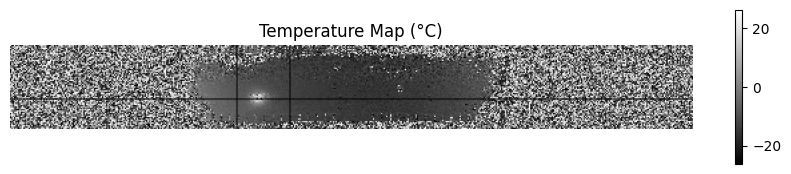

(63, 512)


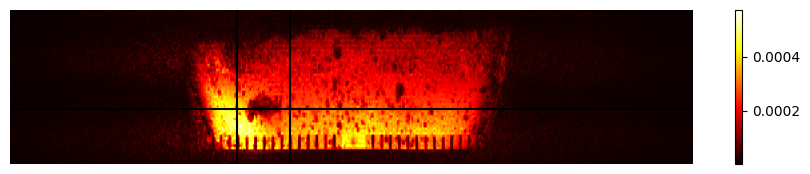

[-24.3 -22.5 -20.8 -19.1 -17.3 -15.6 -13.9 -12.1 -10.4  -8.7  -6.9  -5.2
  -3.5  -1.7   0.    1.7   3.5   5.2   6.9   8.7  10.4  12.1  13.9  15.6
  17.3  19.1  20.8  22.5  24.3  26.   27.7  29.5  31.2  32.9  34.7  36.4
  38.1  39.9  41.6  43.4]
[-30. -20. -10.   0.  10.  20.  30.  40.  50.]
[-30. -20. -10.   0.  10.  20.  30.  40.  50.]


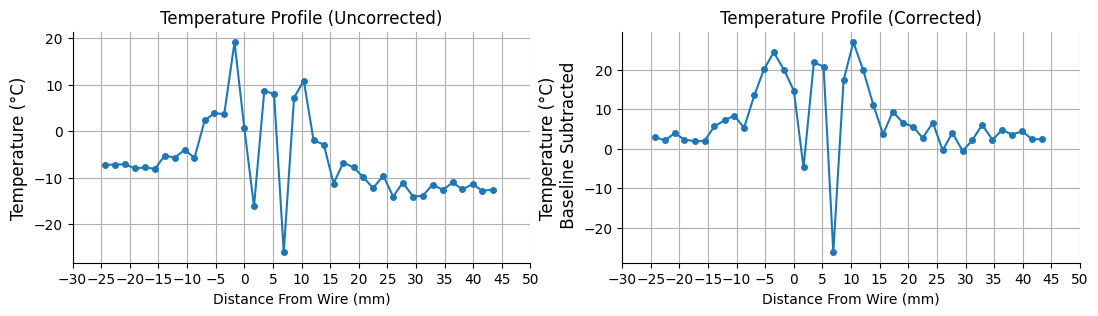

In [14]:
# Calculate temperature map
slice_index = 3
contrast_index = 3

alpha = 0.01e-6 #ppm/C
gyromagnetic_ratio = 267.522e6 #rad/s/T
B0 = 1.494 #T
TE = 0.040 #s

# Do first phase subtraction within acquisition
phase_sub_complex = np.angle(np.multiply(image_pre[contrast_index,slice_index,:,1,:],np.conjugate(image_post[contrast_index,slice_index,:,1,:])))
phase_sub_complex_noimp = np.angle(np.multiply(image_pre_noimp[contrast_index,slice_index,:,1,:],np.conjugate(image_post_noimp[contrast_index,slice_index,:,1,:])))
#temp_map_comb = (phase_img_post - phase_img_pre) / (alpha*gyromagnetic_ratio*B0*TE)
TE = twix_pre[-1]['hdr']['Phoenix']['alTE'][contrast_index]/1e6
print(TE)
temp_map = (phase_sub_complex) / (alpha*gyromagnetic_ratio*B0*TE)
temp_map_noimp = (phase_sub_complex_noimp) / (alpha*gyromagnetic_ratio*B0*TE)

# plt.figure(figsize=[11,2])
# plt.title('Phase Subtraction (Radians)')
# plt.imshow(phase_sub_complex, cmap='gray', origin='lower', aspect='auto')
# plt.colorbar()
# plt.axis('off')
# plt.tight_layout()
# plt.show()


# plt.figure(figsize=[13,2])
# plt.subplot(121)
# plt.title('image')
# plt.imshow(image_rms_pre[contrast_index,slice_index,:,:], cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
# plt.axis('off')

# plt.subplot(122)
# plt.title('Temp Map')
# plt.imshow(temp_map, cmap='gray', origin='lower', aspect='auto')
# plt.axis('off')
# plt.colorbar()
# plt.tight_layout()
# plt.show()

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

xstart, xstop = 170, 210
ystart, ystop = 22, 22

plt.figure(figsize=[11,2])
plt.title('Temperature Map (°C)')
print(temp_map.shape)
plt.plot([0,512],[ystart,ystop], 'k-',alpha=0.5)
plt.plot([xstart,xstart],[0,63], 'k-',alpha=0.5)
plt.plot([xstop,xstop],[0,63], 'k-',alpha=0.5)
plt.imshow(temp_map, origin='lower', cmap='gray')
plt.colorbar()
plt.axis('off')
#plt.tight_layout()
plt.show()

plt.figure(figsize=[11,2])
#plt.title('Temperature Map (°C)')
print(temp_map.shape)
plt.plot([0,512],[ystart,ystop], 'k-',alpha=1)
plt.plot([xstart,xstart],[0,63], 'k-',alpha=1)
plt.plot([xstop,xstop],[0,63], 'k-',alpha=1)
plt.imshow(image_rms_post[contrast_index, slice_index] , aspect='auto', origin='lower',cmap='hot')
plt.axis('off')
plt.colorbar()
#plt.tight_layout()
plt.show()

temp_profile_noimp = moving_average(temp_map_noimp[ystart,xstart:xstop],1)
temp_profile = moving_average(temp_map[ystart,xstart:xstop],1)
temp_drift = 0.5 - temp_profile_noimp

voxel_dist = np.round(np.arange(0,xstop-xstart)*1.734 - 24.276,1)
print(voxel_dist)

%matplotlib inline

title = "Temperature Profiles"
fig = plt.figure(figsize=(13,3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(voxel_dist, temp_profile, linestyle='-', marker='o', markersize=4)
#fig.suptitle(title,fontsize=20)
ax1.set_title("Temperature Profile (Uncorrected)")
ax1.set_xlabel('Distance From Wire (mm)')
ax1.set_ylabel('Temperature (°C)',fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

current_ticks = ax1.get_xticks()
print(current_ticks)
num_ticks = len(current_ticks) * 2 - 1  # This ensures doubling the count
new_step = (current_ticks[-1] - current_ticks[0]) / (num_ticks - 1)
new_ticks = np.linspace(current_ticks[0], current_ticks[-1], num_ticks)
ax1.set_xticks(new_ticks)

ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(voxel_dist, temp_profile + temp_drift, linestyle='-', marker='o', markersize=4)
#fig.suptitle(title,fontsize=20)
ax2.set_title("Temperature Profile (TE 30 ms)")
ax2.set_xlabel('Distance From Wire (mm)')
ax2.set_ylabel('Temperature (°C)\n Baseline Subtracted',fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

current_ticks = ax2.get_xticks()
print(current_ticks)
num_ticks = len(current_ticks) * 2 - 1  # This ensures doubling the count
new_step = (current_ticks[-1] - current_ticks[0]) / (num_ticks - 1)
new_ticks = np.linspace(current_ticks[0], current_ticks[-1], num_ticks)
ax2.set_xticks(new_ticks)

ax2.grid(True)
plt.show()


(4, 2) (4, 32256)


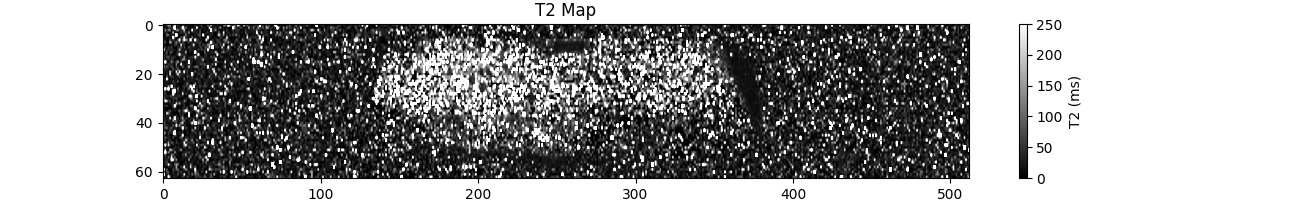

In [29]:
# Do T2* fitting using multiple contrasts

def compute_T2_map_single_slice(images, TE):
    # Shape of the input image array
    contrasts, rows, cols = images.shape
    
    # Reshape the image array to (voxels, contrasts) for vectorized operations
    images_reshaped = images.reshape(contrasts, -1)
    
    # Log-transform the image intensities
    log_images = np.log(images_reshaped)
    
    # Prepare the TE values for linear fitting
    TE = np.array(TE)
    A = np.vstack([TE, np.ones_like(TE)]).T
    print(A.shape, log_images.shape)
    
    # Perform the linear fitting
    slopes, intercepts = np.linalg.lstsq(A, log_images, rcond=None)[0]
    
    # Calculate T2 values
    T2_values = -1 / slopes
    
    # Reshape the T2 map to the original image dimensions
    T2_map = T2_values.reshape(rows, cols)
    T2_map[T2_map < 0] = 0
    
    return T2_map

TE = [4, 10, 20, 30]  # in ms
images = abs(image_pre[:,0,:,1,:])

T2_map = compute_T2_map_single_slice(images, TE)

# Displaying T2 map
plt.figure(figsize=[13,2])
plt.imshow(T2_map, cmap='gray', aspect='auto', vmin=0, vmax=250)
plt.colorbar(label='T2 (ms)')
plt.title('T2 Map')
plt.show()

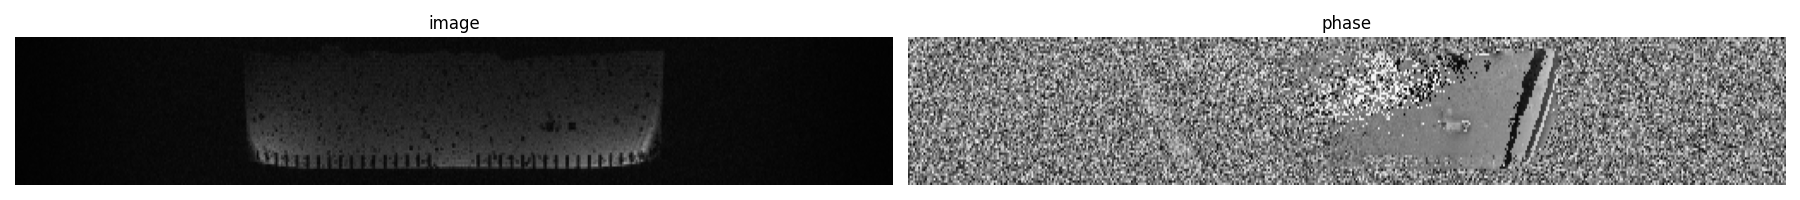

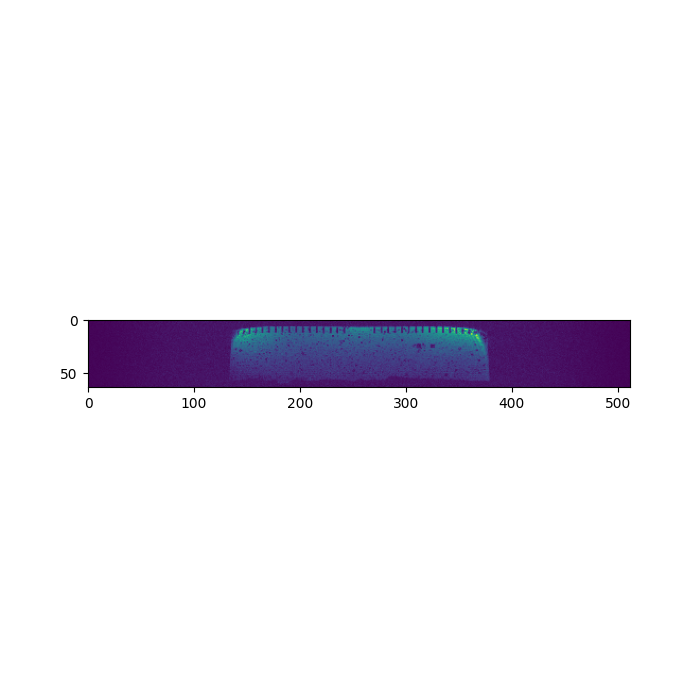

In [29]:
# Now get ROI specific information


def onselect(verts):
    print(verts)

fig = plt.figure(figsize=[12,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_post), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

ax = plt.subplot(122)
plt.title('phase')
ax.imshow(phase_img_pre[:,0,:] - phase_img_post[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

segmenter = image_segmenter(abs(image_rms_post), mask_colors='red', mask_alpha=0.76, figsize=(7, 7))
display(segmenter)


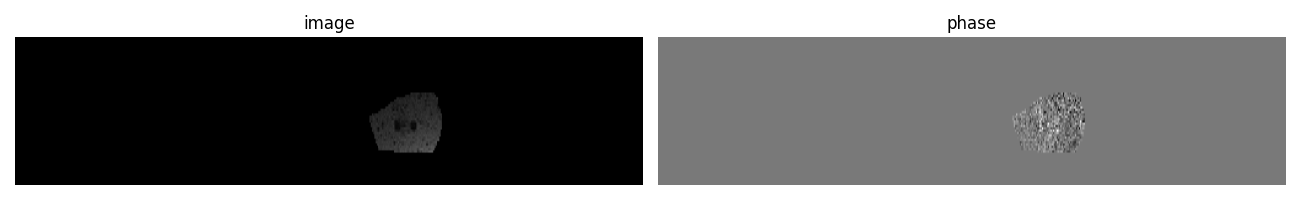

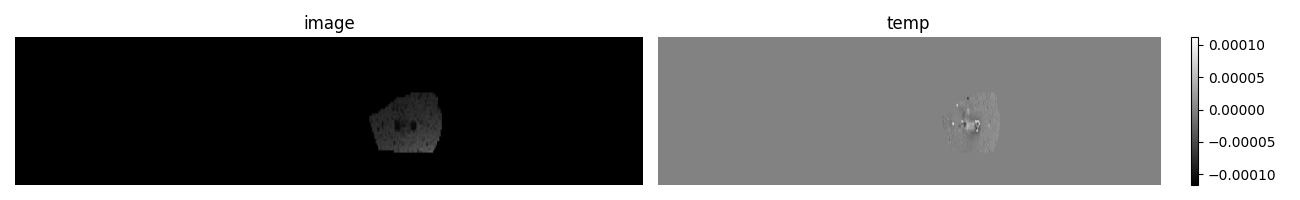

In [38]:
%matplotlib widget

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('phase')
plt.imshow((phase_img_rms_pre - phase_img_rms_post) * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=[13,2])
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms_pre) * segmenter.mask, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

plt.subplot(122)
plt.title('temp')
plt.imshow(temp_map * segmenter.mask, cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.colorbar()
plt.show()

NameError: name 'res' is not defined

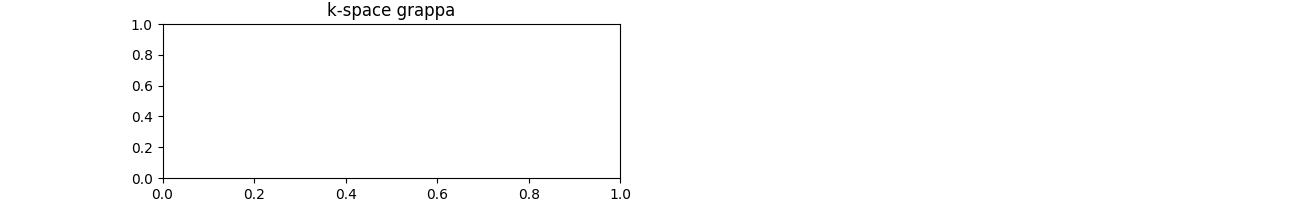

In [31]:
for channel in range(4):

    plt.figure(figsize=[13,2])
    plt.subplot(121)
    plt.title('k-space grappa')
    plt.imshow(abs(res[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    plt.subplot(122)
    plt.title('k-space original')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.figure(figsize=[13,2])
image = ifftnd(res, [0,-1])
image_rms = rms_comb(image)
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

phase_img = np.angle(image)
phase_img_rms = rms_comb(phase_img)
plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
    
plt.tight_layout()

print(np.max(phase_img))

In [11]:
# Now make phase map for pre/post



In [12]:
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|███████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 372MB/s]


In [13]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
print(data.shape)

(10, 63, 4, 512)
